In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


%matplotlib inline

sns.set_theme(style="whitegrid", palette="muted", context="talk", font_scale=1.2)

plt.rcParams.update(
    {
        "figure.figsize": (10, 6),
        "axes.titlesize": 18,
        "axes.labelsize": 16,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 12,
    }
)


warnings.filterwarnings("ignore")

In [2]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    average_precision_score,
    precision_recall_curve,
    auc,
)
from prettytable import PrettyTable


def print_missing_table(train_copy, test_copy, target):
    table = PrettyTable()
    table.field_names = ["Feature", "Data Type", "Train Missing %", "Test Missing %"]

    for column in train_copy.columns:
        data_type = str(train_copy[column].dtype)
        non_null_count_train = np.round(
            100 - train_copy[column].count() / train_copy.shape[0] * 100, 1
        )
        non_null_count_test = (
            np.round(100 - test_copy[column].count() / test_copy.shape[0] * 100, 1)
            if column != target
            else "NA"
        )
        table.add_row([column, data_type, non_null_count_train, non_null_count_test])

    print(table)


def plot_categorical(data, column_name):
    f, ax = plt.subplots(1, 2, figsize=(18, 8))
    data[column_name].value_counts().plot.pie(
        explode=[0, 0.1], autopct="%1.1f%%", ax=ax[0], shadow=True
    )
    ax[0].set_title(column_name)
    ax[0].set_ylabel("")
    sns.countplot(x=column_name, data=data, ax=ax[1])
    ax[1].set_title(column_name)
    plt.show()


def plot_correlation_heatmap(data, numerical_cols, target_col):
    df = data = data[numerical_cols + [target_col]]
    corr = df.corr()
    mask = np.triu(corr)
    plt.figure(figsize=(20, 20))
    sns.heatmap(corr, mask=mask, annot=False, fmt=".4f")
    plt.show()


def plot_roc_curve(y_true, y_score, is_single_fig=False):
    """
    Plot ROC Curve and show AUROC score
    """
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.title("AUROC = {:.4f}".format(roc_auc))
    plt.plot(fpr, tpr, "b")
    plt.plot([0, 1], [0, 1], "r--")
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.ylabel("TPR(True Positive Rate)")
    plt.xlabel("FPR(False Positive Rate)")
    if is_single_fig:
        plt.show()


def plot_pr_curve(y_true, y_score, is_single_fig=False):
    """
    Plot Precision Recall Curve and show AUPRC score
    """
    prec, rec, thresh = precision_recall_curve(y_true, y_score)
    avg_prec = average_precision_score(y_true, y_score)
    plt.title("AUPRC = {:.4f}".format(avg_prec))
    plt.step(rec, prec, color="b", alpha=0.2, where="post")
    plt.fill_between(rec, prec, step="post", alpha=0.2, color="b")
    plt.plot(rec, prec, "b")
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    if is_single_fig:
        plt.show()


def plot_conf_mtx(
    y_true, y_score, thresh=0.5, class_labels=["0", "1"], is_single_fig=False
):
    """
    Plot Confusion matrix
    """
    y_pred = np.where(y_score >= thresh, 1, 0)
    print("confusion matrix (cutoff={})".format(thresh))
    print(classification_report(y_true, y_pred, target_names=class_labels))
    conf_mtx = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        conf_mtx,
        xticklabels=class_labels,
        yticklabels=class_labels,
        annot=True,
        fmt="d",
    )
    plt.title("Confusion Matrix")
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    if is_single_fig:
        plt.show()


# https://github.com/aws-samples/autogluon-on-aws/blob/main/1.tabular/src/utils.py
def plot_all(y_true, y_score, thresh=0.5):
    if y_true.dtype == "object":
        y_true, uniques = pd.factorize(y_true)

    fig = plt.figure(figsize=(14, 4))
    plt.subplot(1, 3, 1)
    plot_roc_curve(y_true, y_score)
    plt.subplot(1, 3, 2)
    plot_pr_curve(y_true, y_score)
    plt.subplot(1, 3, 3)
    plot_conf_mtx(y_true, y_score, thresh)

In [3]:
# Load datasets
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
solution_format = pd.read_csv("data/solution_format.csv")

In [4]:
print("train shape: ", train.shape)
print("test shape: ", test.shape)
print("solution format shape: ", solution_format.shape)

train shape:  (2660, 78)
test shape:  (666, 77)
solution format shape:  (666, 2)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2660 entries, 0 to 2659
Data columns (total 78 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             2660 non-null   int64  
 1   TR_1_EventInd  73 non-null     float64
 2   TR_2_EventInd  61 non-null     float64
 3   TR_3_EventInd  97 non-null     float64
 4   feature_10_A   2212 non-null   float64
 5   feature_10_B   1843 non-null   float64
 6   feature_10_F   2212 non-null   float64
 7   feature_10_G   2212 non-null   float64
 8   feature_1_A    1844 non-null   float64
 9   feature_1_B    1844 non-null   float64
 10  feature_1_C    1840 non-null   float64
 11  feature_1_D    1840 non-null   float64
 12  feature_1_E    1742 non-null   float64
 13  feature_1_F    1844 non-null   float64
 14  feature_1_G    1844 non-null   float64
 15  feature_2_A    1844 non-null   float64
 16  feature_2_B    1844 non-null   float64
 17  feature_2_C    1840 non-null   float64
 18  feature_

In [6]:
train.head()

,ID,TR_1_EventInd,TR_2_EventInd,TR_3_EventInd,feature_10_A,feature_10_B,feature_10_F,feature_10_G,feature_1_A,feature_1_B,...,feature_9_F,feature_9_G,feature_X_A,feature_X_B,feature_X_C,feature_X_D,index_1,index_2,index_3,Target
0,1,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,...,NaN,NaN,1,0.049,1.542456,-0.274727,0.0,0.0,1.0,0
1,2,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,...,NaN,NaN,1,0.015,1.287473,-1.140626,NaN,NaN,NaN,0
2,3,NaN,NaN,NaN,0.0,0.023,0.0,0.0,1.0,0.004,...,0.0,1.0,1,0.006,0.251501,-1.221567,NaN,NaN,NaN,0
3,4,NaN,NaN,NaN,1.0,0.019,0.0,2.0,0.0,0.005,...,0.0,0.0,1,0.039,1.673783,0.527796,NaN,NaN,NaN,1
4,5,NaN,NaN,1.0,1.0,0.023,0.0,2.0,1.0,0.014,...,1.0,2.0,0,0.037,0.263406,-0.301984,NaN,NaN,NaN,0


In [7]:
# Unique value counts for each column
unique_counts = train.nunique()

# Threshold to distinguish continuous and categorical
threshold = 12

# Select only numeric columns for continuous variables
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()

continuous_vars = unique_counts[
    (unique_counts > threshold) & unique_counts.index.isin(numeric_cols)
].index.tolist()
categorical_vars = unique_counts[
    (unique_counts <= threshold) | ~unique_counts.index.isin(numeric_cols)
].index.tolist()

target_col = "Target"
id_col = ["ID"]

if target_col in categorical_vars:
    categorical_vars.remove(target_col)

for col in id_col:
    if col in continuous_vars:
        continuous_vars.remove(col)

print(f"Categorical Variables: {categorical_vars}")
print(f"Continuous/Numerical Variables: {continuous_vars}")

Categorical Variables: ['TR_1_EventInd', 'TR_2_EventInd', 'TR_3_EventInd', 'feature_10_A', 'feature_10_F', 'feature_10_G', 'feature_1_A', 'feature_1_F', 'feature_1_G', 'feature_2_A', 'feature_2_F', 'feature_2_G', 'feature_3_A', 'feature_3_F', 'feature_3_G', 'feature_4_A', 'feature_4_F', 'feature_4_G', 'feature_5_A', 'feature_5_F', 'feature_5_G', 'feature_6_A', 'feature_6_F', 'feature_6_G', 'feature_7_A', 'feature_7_F', 'feature_7_G', 'feature_8_A', 'feature_8_F', 'feature_9_A', 'feature_9_F', 'feature_9_G', 'feature_X_A', 'index_1']
Continuous/Numerical Variables: ['feature_10_B', 'feature_1_B', 'feature_1_C', 'feature_1_D', 'feature_1_E', 'feature_2_B', 'feature_2_C', 'feature_2_D', 'feature_2_E', 'feature_3_B', 'feature_3_C', 'feature_3_D', 'feature_3_E', 'feature_4_B', 'feature_4_C', 'feature_4_E', 'feature_5_B', 'feature_5_C', 'feature_5_D', 'feature_5_E', 'feature_6_B', 'feature_6_C', 'feature_6_D', 'feature_6_E', 'feature_7_B', 'feature_7_C', 'feature_7_D', 'feature_7_E', 'featur

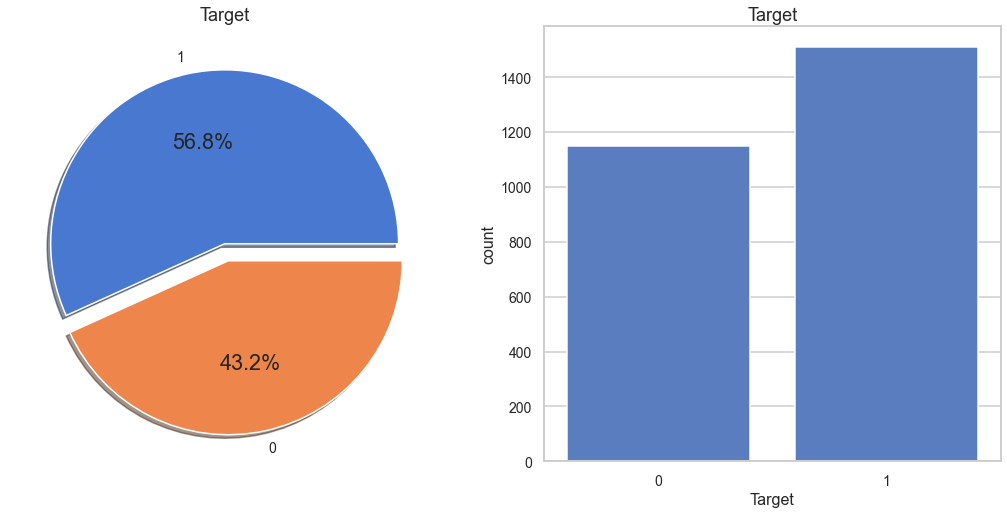

In [8]:
plot_categorical(train, column_name="Target")

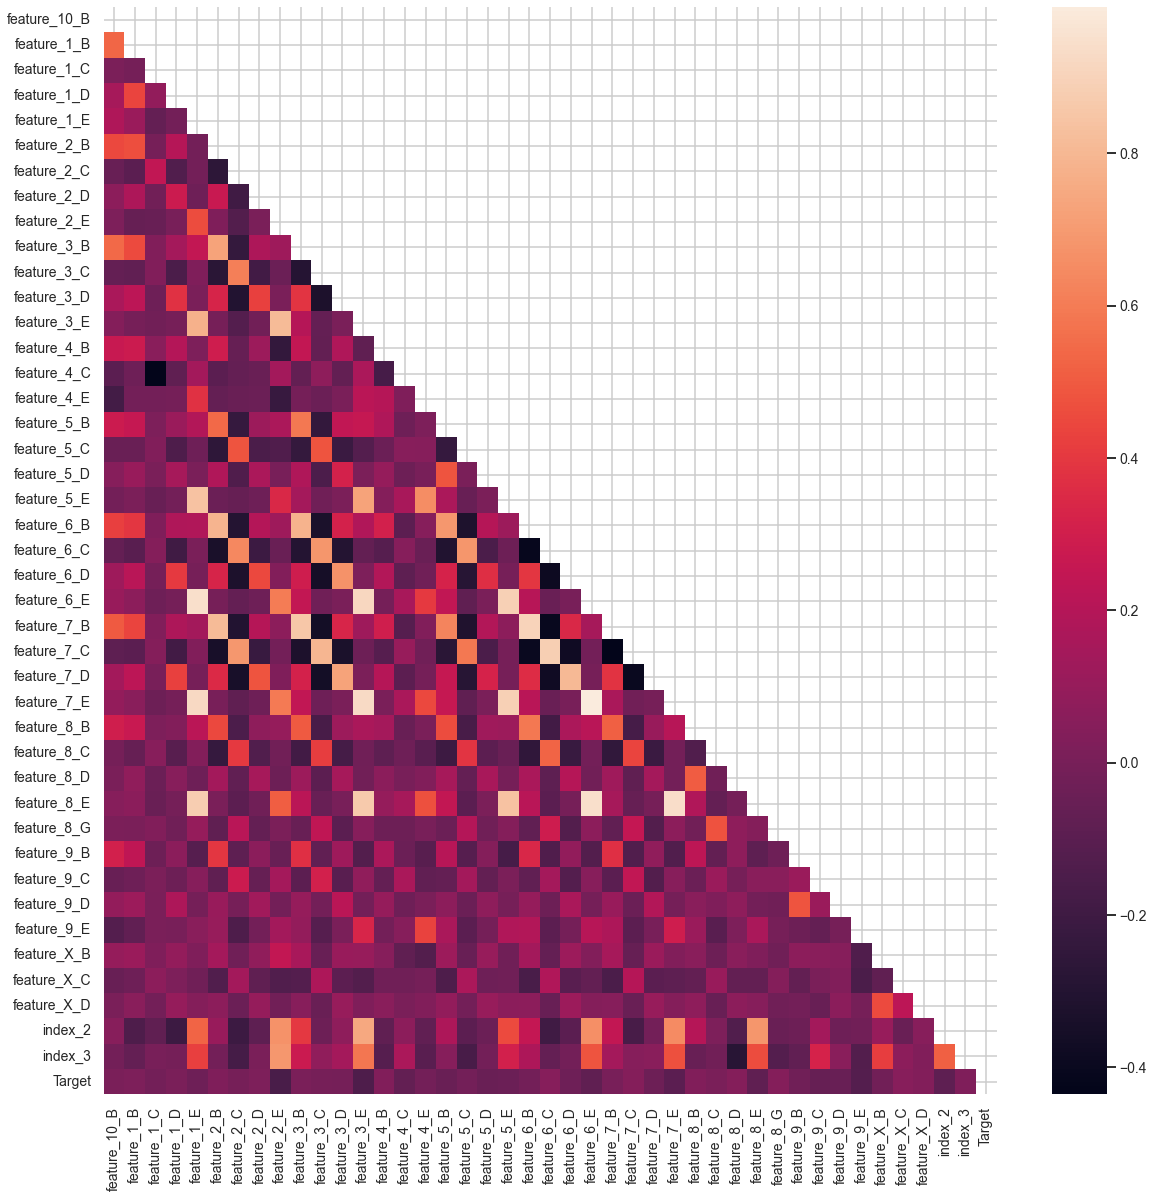

In [9]:
plot_correlation_heatmap(train, continuous_vars, target_col)

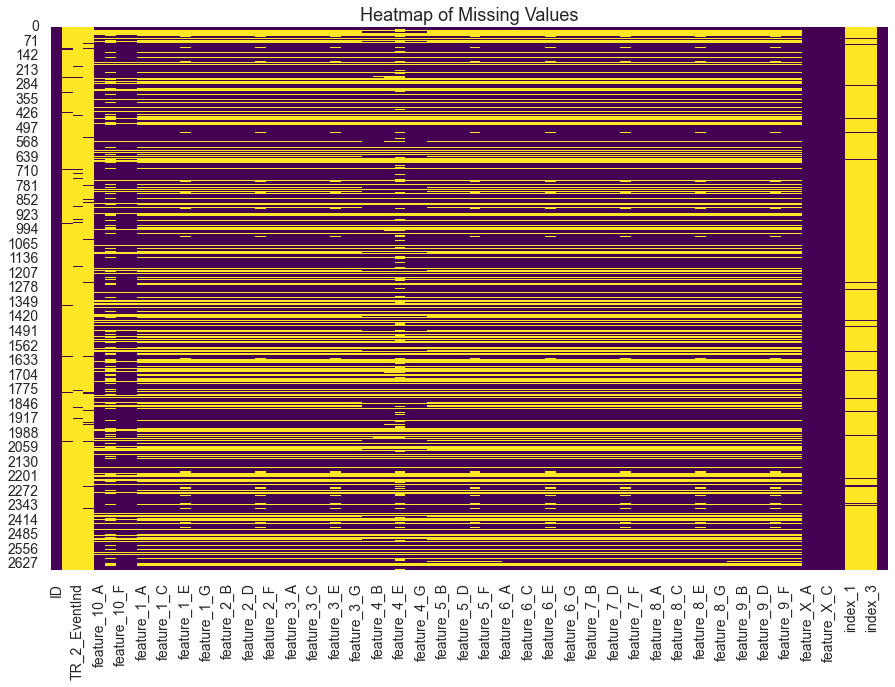

In [10]:
# Plotting the missing values heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(train.isnull(), cbar=False, cmap="viridis")
plt.title("Heatmap of Missing Values")
plt.show()

In [11]:
print_missing_table(train, test, "Target")

+---------------+-----------+-----------------+----------------+
|    Feature    | Data Type | Train Missing % | Test Missing % |
+---------------+-----------+-----------------+----------------+
|       ID      |   int64   |       0.0       |      0.0       |
| TR_1_EventInd |  float64  |       97.3      |      98.0      |
| TR_2_EventInd |  float64  |       97.7      |      98.3      |
| TR_3_EventInd |  float64  |       96.4      |      95.3      |
|  feature_10_A |  float64  |       16.8      |      16.5      |
|  feature_10_B |  float64  |       30.7      |      33.0      |
|  feature_10_F |  float64  |       16.8      |      16.5      |
|  feature_10_G |  float64  |       16.8      |      16.5      |
|  feature_1_A  |  float64  |       30.7      |      32.9      |
|  feature_1_B  |  float64  |       30.7      |      32.9      |
|  feature_1_C  |  float64  |       30.8      |      33.0      |
|  feature_1_D  |  float64  |       30.8      |      33.0      |
|  feature_1_E  |  float6

In [12]:
# !pip install autogluon ipywidgets -Uqq

In [13]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(train, test_size=0.33, random_state=1)
df_train.shape, df_test.shape

label = "Target"
print(f"Unique classes: {list(df_train[label].unique())}")
print(f"Unique classes: {list(df_train[label].value_counts())}")

Unique classes: [1, 0]
Unique classes: [993, 789]


In [14]:
y_test = df_test[label]  # values to predict
test_data_nolab = df_test.drop(columns=[label])

## training


In [16]:
from autogluon.tabular import TabularPredictor

time_limit = 2 * 60  # 2 minutes
metric = "f1"
save_path = "ag-01-binary"


predictor = TabularPredictor(label=label, eval_metric=metric, path=save_path).fit(
    df_train,
    num_bag_folds=5,
    num_bag_sets=1,
    num_stack_levels=1,
    time_limit=time_limit,
)

No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ... Time limit = 120s
AutoGluon will save models to "ag-01-binary"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.9.10
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.4.0: Fri Mar 15 00:12:41 PDT 2024; root:xnu-10063.101.17~1/RELEASE_ARM64_T8103
CPU Count:          8
Memory Avail:

## evaluation


In [17]:
print("AutoGluon infers problem type is: ", predictor.problem_type)
print("AutoGluon identified the following types of features:")
print(predictor.feature_metadata)

AutoGluon infers problem type is:  binary
AutoGluon identified the following types of features:
('float', [])     : 71 | ['feature_10_A', 'feature_10_B', 'feature_10_G', 'feature_1_A', 'feature_1_B', ...]
('int', [])       :  1 | ['ID']
('int', ['bool']) :  5 | ['TR_1_EventInd', 'TR_2_EventInd', 'TR_3_EventInd', 'feature_10_F', 'feature_X_A']


In [18]:
y_pred = predictor.predict(test_data_nolab)
y_pred.head()

1503    1
275     1
620     1
2341    0
1661    1
Name: Target, dtype: int64

In [19]:
y_prob = predictor.predict_proba(test_data_nolab)
y_prob.head()

,0,1
1503,0.482658,0.517342
275,0.280802,0.719198
620,0.169536,0.830464
2341,0.779325,0.220675
1661,0.497511,0.502489


In [20]:
perf = predictor.evaluate_predictions(
    y_true=y_test, y_pred=y_pred, auxiliary_metrics=True
)

confusion matrix (cutoff=0.5)
              precision    recall  f1-score   support

           0       0.67      0.54      0.60       361
           1       0.72      0.82      0.76       517

    accuracy                           0.70       878
   macro avg       0.70      0.68      0.68       878
weighted avg       0.70      0.70      0.70       878



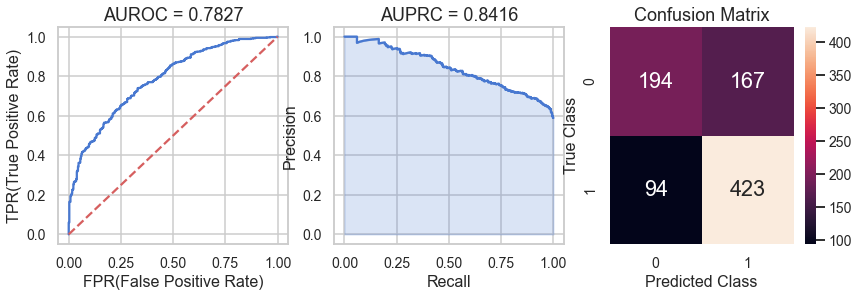

In [21]:
y_prob = predictor.predict_proba(test_data_nolab)
y_prob_ = y_prob.iloc[:, -1]
plot_all(y_test, y_prob_)

In [22]:
results = predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val eval_metric  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       WeightedEnsemble_L3   0.766868          f1       0.744156  3.217280                0.002118           0.980074            3       True         12
1     ExtraTreesEntr_BAG_L2   0.759624          f1       0.605446  1.577179                0.069608           0.272599            2       True         11
2   RandomForestEntr_BAG_L2   0.746769          f1       0.602650  1.701075                0.066812           0.396495            2       True          9
3     ExtraTreesGini_BAG_L2   0.745763          f1       0.605618  1.568112                0.069780           0.263532            2       True         10
4   RandomForestGini_BAG_L2   0.743762          f1       0.603058  1.670384                0.067220           0.365804            2       True          8
5       Weight

In [23]:
predictor.leaderboard(silent=True)

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.766868,f1,0.744156,3.217280,0.002118,0.980074,3,True,12
1,ExtraTreesEntr_BAG_L2,0.759624,f1,0.605446,1.577179,0.069608,0.272599,2,True,11
2,RandomForestEntr_BAG_L2,0.746769,f1,0.602650,1.701075,0.066812,0.396495,2,True,9
3,ExtraTreesGini_BAG_L2,0.745763,f1,0.605618,1.568112,0.069780,0.263532,2,True,10
4,RandomForestGini_BAG_L2,0.743762,f1,0.603058,1.670384,0.067220,0.365804,2,True,8
5,WeightedEnsemble_L2,0.736648,f1,0.280832,1.905797,0.002125,0.610783,2,True,7
6,RandomForestEntr_BAG_L1,0.722405,f1,0.068416,0.393537,0.068416,0.393537,1,True,4
7,RandomForestGini_BAG_L1,0.712121,f1,0.068936,0.349701,0.068936,0.349701,1,True,3
8,ExtraTreesGini_BAG_L1,0.694329,f1,0.070304,0.257018,0.070304,0.257018,1,True,5
9,ExtraTreesEntr_BAG_L1,0.691736,f1,0.071051,0.294758,0.071051,0.294758,1,True,6


In [24]:
predictor.model_best

'WeightedEnsemble_L3'

In [25]:
predictor.model_names()

['KNeighborsUnif_BAG_L1',
 'KNeighborsDist_BAG_L1',
 'RandomForestGini_BAG_L1',
 'RandomForestEntr_BAG_L1',
 'ExtraTreesGini_BAG_L1',
 'ExtraTreesEntr_BAG_L1',
 'WeightedEnsemble_L2',
 'RandomForestGini_BAG_L2',
 'RandomForestEntr_BAG_L2',
 'ExtraTreesGini_BAG_L2',
 'ExtraTreesEntr_BAG_L2',
 'WeightedEnsemble_L3']

In [26]:
predictor.feature_importance(df_test)

Computing feature importance via permutation shuffling for 77 features using 878 rows with 5 shuffle sets...
	192.29s	= Expected runtime (38.46s per shuffle set)
	15.97s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
feature_4_F,0.018949,0.004892,0.000489,5,0.029022,0.008876
feature_2_E,0.017711,0.004618,0.000508,5,0.027220,0.008203
feature_10_F,0.017400,0.004104,0.000345,5,0.025850,0.008949
feature_4_E,0.012954,0.005669,0.003467,5,0.024626,0.001283
feature_X_C,0.011958,0.004257,0.001641,5,0.020724,0.003192
...,...,...,...,...,...,...
feature_9_F,-0.005970,0.002970,0.994566,5,0.000145,-0.012086
feature_6_D,-0.006332,0.002454,0.997761,5,-0.001280,-0.011384
feature_6_A,-0.006880,0.003077,0.996252,5,-0.000544,-0.013216
feature_2_F,-0.007688,0.005077,0.986185,5,0.002765,-0.018140


## predict on test set


In [27]:
predictor = TabularPredictor.load("ag-01-binary")

y_pred = predictor.predict(test)

# create submission file
submission = pd.DataFrame({"ID": test["ID"], "Target": y_pred})
submission.to_csv("submission.csv", index=False)

In [28]:
submission.head()

,ID,Target
0,2661,1
1,2662,1
2,2663,1
3,2664,1
4,2665,1


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a605a3e6-1564-47b2-94e7-842290ba7692' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>